In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


# Import Dataset

In [ ]:
import pandas as pd


data = pd.read_excel('/gdrive/MyDrive/InFenTor/DATASET_BETA.xlsx')
data.dropna(inplace=True)
data.head()

In [ ]:
data['karir'] = data['karir'].replace('Desainer', 'Designer')
df = data.copy()

In [ ]:
df.karir.value_counts()

In [ ]:
jumlah_col = 2000

In [ ]:
df1 = df[df['karir'] == "IT"]
df1 = df1.sample(frac=1, random_state=42)
df1 = df1.head(jumlah_col)

df2 = df[df['karir'] == "Kesehatan"]
df2 = df2.sample(frac=1, random_state=42)
df2 = df2.head(jumlah_col)

df3 = df[df['karir'] == "Akuntan"]
df3 = df3.sample(frac=1, random_state=42)
df3 = df3.head(jumlah_col)

df4 = df[df['karir'] == "Guru"]
df4 = df4.sample(frac=1, random_state=42)
df4 = df4.head(jumlah_col)

df5 = df[df['karir'] == "Designer"]
df5 = df5.sample(frac=1, random_state=42)
df5 = df5.head(jumlah_col)

In [ ]:
df_merge = pd.concat([df1, df2, df3, df4 , df5])
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 78376 to 22152
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   karir   10000 non-null  object
 1   text    10000 non-null  object
dtypes: object(2)
memory usage: 234.4+ KB


In [ ]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('stopwords')
nltk.download('wordnet')


In [ ]:
import re
def preprocess_text(text):
    # Mengubah teks menjadi huruf kecil
    text = text.lower()

    # Menghapus tanda baca dan karakter selain alfabet
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    return text

df_merge['text'] = df_merge['text'].apply(preprocess_text)



In [ ]:
df_merge = df_merge.sample(frac=1, random_state=42)

df_merge.head()

,karir,text
29436,Guru,headteacher mr russell boulton hour per week t...
1201,Akuntan,manajer regional tahun baru tantangan baru kli...
76355,IT,analis bisnis berpenampilan kota berbasis peru...
18219,Akuntan,mencari peran yang menantang namun menarik bek...
2898,Akuntan,hutang akun emea hari manajer ssc berkshire pe...


# Modelling

In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling1D, GlobalMaxPooling1D, LSTM, Dropout, GRU, Activation, Embedding, Bidirectional,SpatialDropout1D, BatchNormalization, Conv1D, MaxPool1D

In [ ]:
data = df_merge.copy()

In [ ]:
MAX_NB_WORDS = 5000
# Max number of words in each description.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.

EMBEDDING_DIM = 100

In [ ]:

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS,
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True, oov_token='OOV')

# Fit Tokenizer
tokenizer.fit_on_texts(data['text'].values)

# Jadikan menjadi Sequences
X = tokenizer.texts_to_sequences(data['text'].values)

In [ ]:
word_index = tokenizer.word_index

import json

# Menyimpan word_index sebagai file JSON
with open('/gdrive/MyDrive/InFenTor/tokenizer_word_index_try_pertama.json', 'w') as f:
    json.dump(word_index, f)

In [ ]:
word_index = tokenizer.word_index
word_index

In [ ]:
# agar sama panjang

X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
tokenizer.texts_to_sequences(["saya suka menggambar gedung"])

[[3379, 1597, 2188, 1]]

In [ ]:
# Melihat tokenizer kita
# tokenizer.word_index

In [ ]:
replace_category = {
'Akuntan':0, 'Designer':1, 'Guru':2, 'Kesehatan':3, 'IT':4
}
Y = pd.get_dummies(data.replace({"karir": replace_category})['karir'].values)
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (10000, 5)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9000, 250) (9000, 5)
(1000, 250) (1000, 5)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, 300, input_length=X.shape[1]))
model.add(LSTM(256, dropout=0.5, recurrent_dropout=0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)



In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 300)          3000000   
                                                                 
 lstm_3 (LSTM)               (None, 256)               570368    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 3,603,909
Trainable params: 3,603,909
Non-trainable params: 0
_________________________________________________________________


16/16 [==============================] - 1s 80ms/step - loss: 0.7448 - accuracy: 0.8040
Test set
  Loss: 0.745
  Accuracy: 0.804


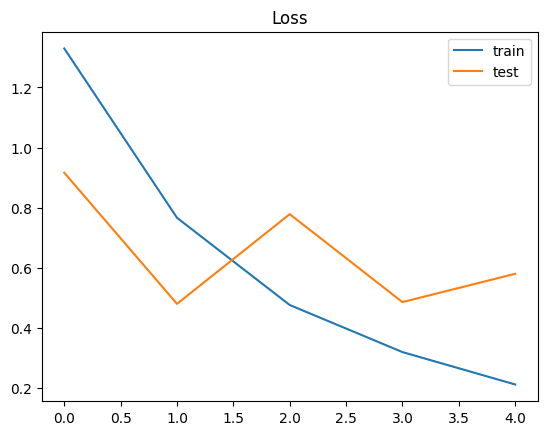

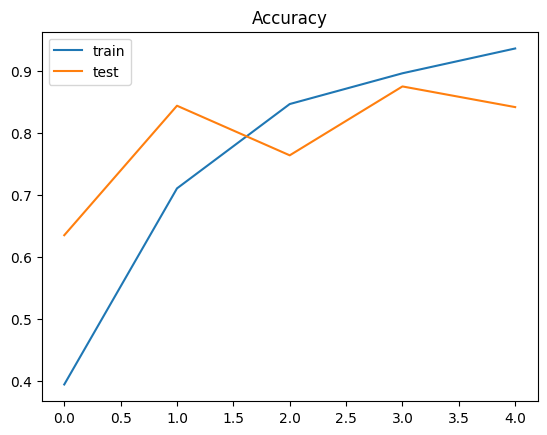

In [ ]:
import matplotlib.pyplot as plt

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
# Simpan model Keras dalam format SavedModel
tf.saved_model.save(model, '/gdrive/MyDrive/InFenTor/saved_model')

In [ ]:
# Simpan model ke file HDF5
model.save('/gdrive/MyDrive/InFenTor/model_kedua_embed10k.h5')